In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sb
import os
import ipykernel
import pathlib

In [10]:
notebook_path = pathlib.Path(ipykernel.get_connection_file()).parent.resolve()

print(notebook_path)

C:\Users\fer_g\AppData\Roaming\jupyter\runtime


In [95]:
df_master = pd.read_csv('C:/Users/fer_g/Downloads/master_data.csv')
#drop the index and date columns
df_master = df_master.drop(columns=['id', 'date'])

#convert the start_time column to minutes after midnight
df_master['start_time'] = pd.to_datetime(df_master['start_time'] , format='%H:%M:%S')
df_master['start_time'] = df_master['start_time'].dt.hour * 60 + df_master['start_time'].dt.minute

#drop the rows with missing values
df_master = df_master.dropna()

#drop total snow column
df_master=df_master.drop(columns=['total_snow'])

#change bus lines [67, 80, 100, 121, 139, 439, 467, 480] to numbers 1-8
df_master['line'] = df_master['line'].replace([67, 80, 100, 121, 139, 439, 467, 480], [1, 2, 3, 4, 5, 6, 7, 8])


plot delays against end time for each busline
find delays over a certain number, if the next delay is also over that number, separate that busline and day


In [96]:
df_test = df_master

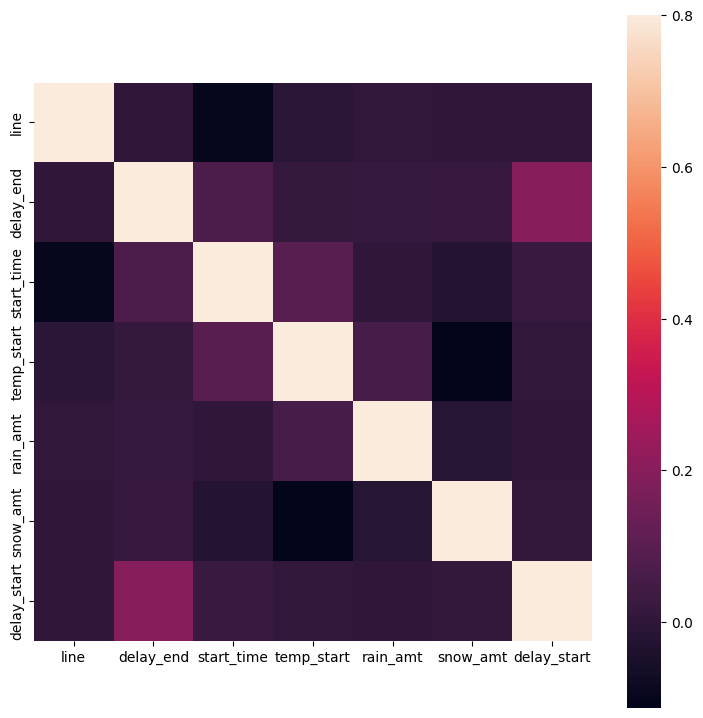

In [97]:
Corr_mat = df_test.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

In [98]:
predictors = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'snow_amt', 'line']
outcome = 'delay_end'

In [99]:
for i in range(len(predictors)):
    for j in range(len(predictors)):
        if i<j:
            corr, _ = pearsonr(df_test[predictors[i]], df_test[predictors[j]])
            print('The correlation between', predictors[i], 'and', predictors[j], 'is', corr)

The correlation between delay_start and start_time is 0.02443191113084113
The correlation between delay_start and temp_start is 0.005926468145248256
The correlation between delay_start and rain_amt is 0.00391874668369688
The correlation between delay_start and snow_amt is 0.008249960576945126
The correlation between delay_start and line is 0.0023397907206628207
The correlation between start_time and temp_start is 0.10077189984427724
The correlation between start_time and rain_amt is 0.00425334001924677
The correlation between start_time and snow_amt is -0.024176273843384725
The correlation between start_time and line is -0.102027159561625
The correlation between temp_start and rain_amt is 0.05680562338511451
The correlation between temp_start and snow_amt is -0.11309762999522527
The correlation between temp_start and line is -0.010416159670381215
The correlation between rain_amt and snow_amt is -0.018916201405556533
The correlation between rain_amt and line is 0.005195154409556082
The 

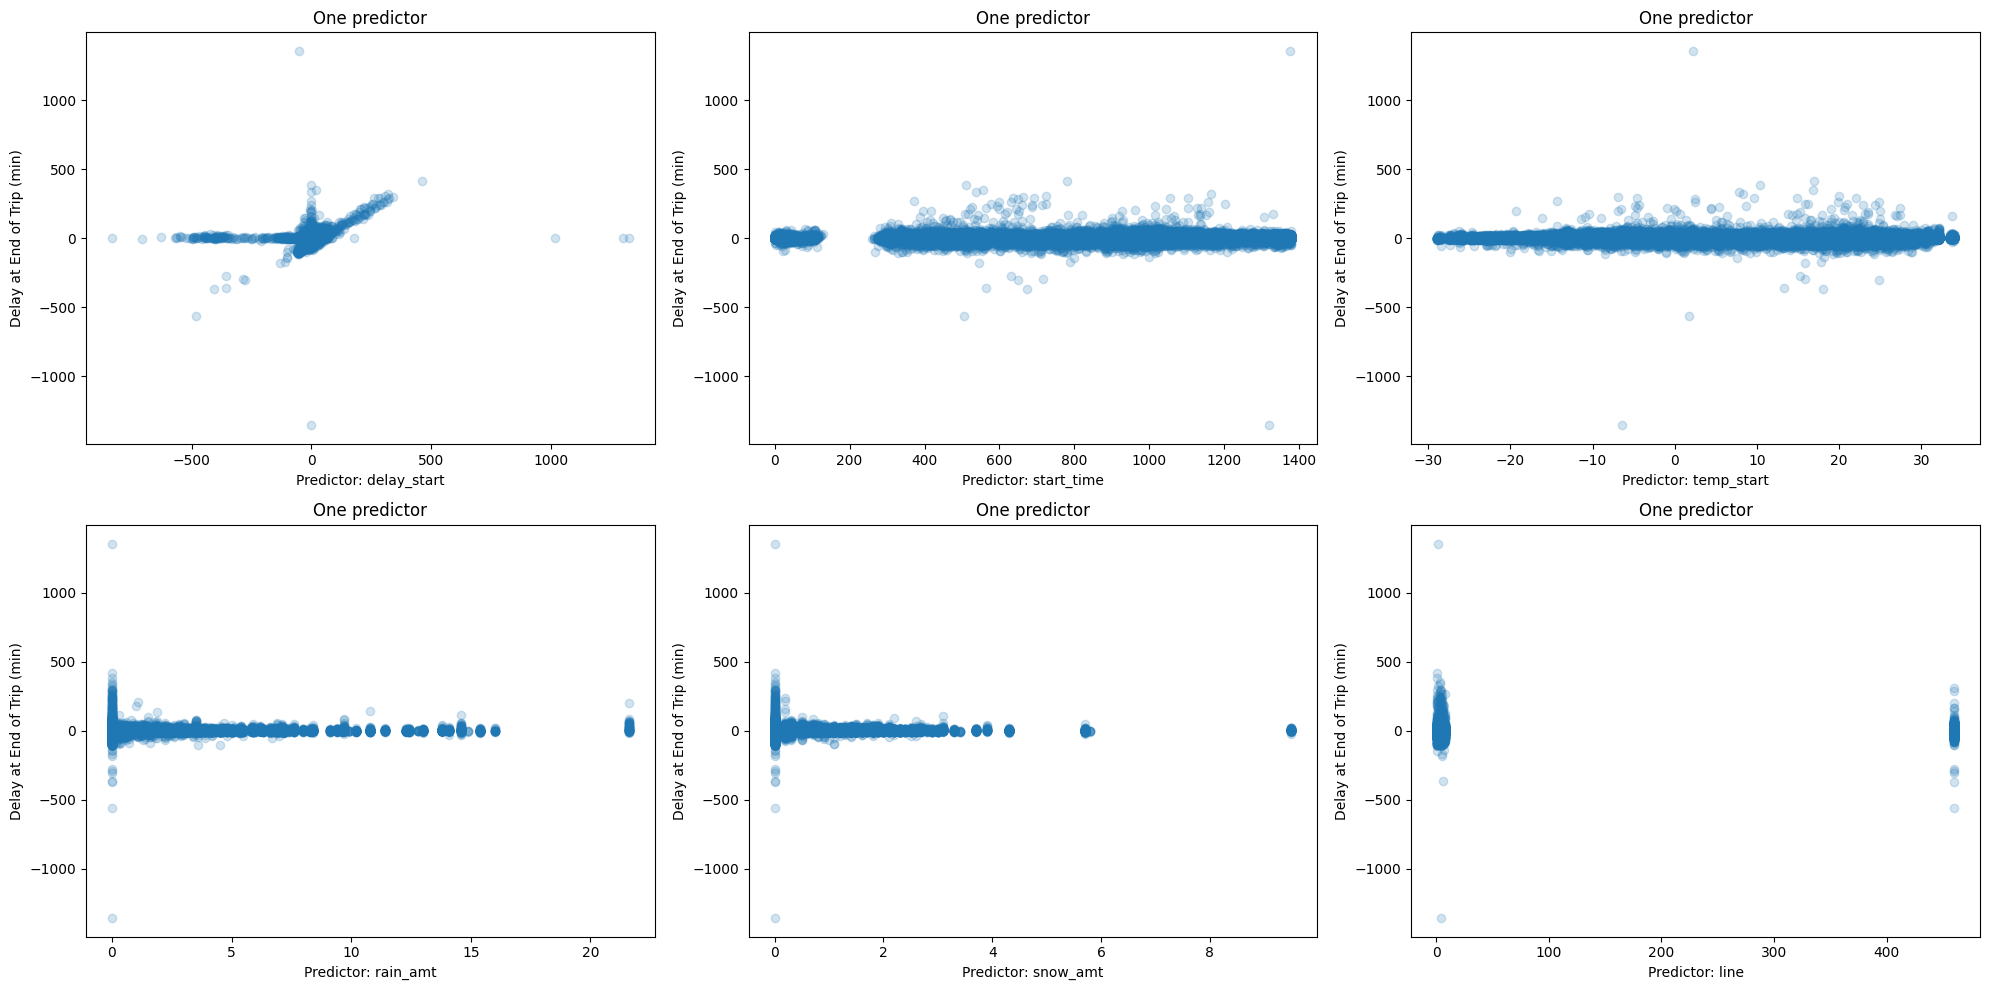

In [100]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, axi in enumerate(ax.flat):
    axi.scatter(df_test[predictors[i]], df_test[outcome], color='tab:blue', alpha=0.2)
    axi.set_ylabel('Delay at End of Trip (min)')
    axi.set_xlabel(f'Predictor: {predictors[i]}')
    axi.set_title("One predictor");

plt.tight_layout()
plt.show()

In [87]:
predictors2 = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'snow_amt']

In [88]:
model = sm.OLS(df_test[outcome], df_test[predictors2].assign(const=1))
results = model.fit()

In [89]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     6241.
Date:                Wed, 15 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:33:52   Log-Likelihood:            -2.4357e+06
No. Observations:              697550   AIC:                         4.871e+06
Df Residuals:                  697544   BIC:                         4.871e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2084      0.001    164.218      0.000       0.206       0.211
start_time      0.0017   3.01e-05     55.086      0.000       0.002       0.002
temp_start      0.0050      0.001      6.215      0.000       0.003       0.007
rain_amt        0.2059      0.014     14.346      0.000       0.178       0.234
snow_amt        0.8279      0.043     19.384      0.000       0.744       0.912
const           0.9452      0.026     36.900      0.000       0.895       0.995
==============================================================================
Omnibus:                   539082.169   Durbin-Watson:                   1.545
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     189635850964.986
Skew:                           1.506   Prob(JB):                         0.00
Kurtosis:                    2557.335   Cond. No.                     3.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
mse = results.mse_resid

In [91]:
mse**0.5

7.947180771207456

In [92]:
results.params

delay_start    0.208449
start_time     0.001656
temp_start     0.004989
rain_amt       0.205937
snow_amt       0.827861
const          0.945242
dtype: float64

In [93]:
para = results.params
delay = 2
time = 7*60 + 30
temp = 15
rain = 0.1
snow = 0

X = [delay, time, temp, rain, snow,1]
prediction = np.dot(para, X)
print(f"The bus should be delayed by {prediction} minutes.")


The bus should be delayed by 2.2026542924504553 minutes.
